# Imports

In [13]:
import pandas as pd
import psycopg2

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

# Backup Csv

In [14]:
data = pd.read_csv("DataJoined.csv", index_col=0) 
data = data.dropna()

In [15]:
df_joined = data.copy()
df_joined = df_joined[(df_joined.pedId != 16)  & (df_joined.pedId != 17)  & (df_joined.speed > 0)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]
df_joined.head()

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time.1,steering,brake,throttle
2017-10-04 12:50:28.400,2017-10-04 12:50:28.383484,144.0,1.0,-975.703700,82.260376,0.0,1.0,0.0,89.979675,0.013278,-885.6892,70.21315,1253.45900,2017-10-04 12:50:28.384988,32307.0,65535.0,65535.0
2017-10-04 12:50:28.450,2017-10-04 12:50:28.437127,144.0,1.0,-975.709534,82.251080,0.0,1.0,0.0,89.984790,0.135856,-885.6892,70.21315,1253.46400,2017-10-04 12:50:28.444647,32307.0,65535.0,65535.0
2017-10-04 12:50:28.500,2017-10-04 12:50:28.494279,144.0,1.0,-975.714233,82.246090,0.0,1.0,0.0,89.988880,0.125762,-885.6892,70.21315,1253.46814,2017-10-04 12:50:28.484754,32307.0,65535.0,65535.0
2017-10-04 12:50:28.550,2017-10-04 12:50:28.520850,144.0,1.0,-975.716000,82.244156,0.0,1.0,0.0,89.990330,0.102796,-885.6892,70.21315,1253.46960,2017-10-04 12:50:28.544914,32307.0,65535.0,65535.0
2017-10-04 12:50:28.600,2017-10-04 12:50:28.584519,144.0,1.0,-975.718100,82.241540,0.0,1.0,0.0,89.991715,0.047856,-885.6892,70.21315,1253.47168,2017-10-04 12:50:28.585020,32307.0,65535.0,65535.0


## Clean Data

In [16]:
df_joined['steering'] = df_joined['steering'].divide(65535)
df_joined['brake'] = df_joined['brake'].divide(65535)
df_joined['throttle'] = df_joined['throttle'].divide(65535)
df_joined['acceleration'] = df_joined['speed'].diff()
df_joined = df_joined[(df_joined.pedId != 16)  & (df_joined.pedId != 17)  & (df_joined.speed > 0)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]

# Fix time

In [17]:
#df_joined_fixed = df_joined[(df_joined.pedId == 15)  & (df_joined.scenario == 1)  & (df_joined.session_id == 144) & (df_joined.currentDistance < 345) & (df_joined.currentDistance > 315)]
#df_joined_fixed = df_joined[(df_joined.pedId == 19)  & (df_joined.scenario == 2)  & (df_joined.session_id == 152) & (df_joined.distancePed < 30) ]
#df_joined_fixed = df_joined[ (df_joined.scenario == 2)  & (df_joined.session_id == 144) & (df_joined.currentDistance < 1235) & (df_joined.currentDistance > 1190)]
#df_joined = df_joined[(df_joined.distancePed < 30)]
df_joined = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).tail(200)

#df_joined_fixed

# Means fields

In [18]:
means = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
#clean the ones in which didnt run the pedestrian
means = means[means.nextPedRunning != 0]
means_cleaned = means.drop(means.columns[[3,4,6,7,9,10,11]], axis=1)

#means_cleaned = means.dropna(thresh=11)
#df_joined = df_joined[df_joined.notnull()]
#session_id	scenario	pedId	hadCollision speed		steering	brake	throttle	acceleration
##means_cleaned['hadCollision'] = np.where(means_cleaned['hadCollision'] == 0, False, True)

#means_cleaned.drop(means_cleaned[means_cleaned.nextPedRunning == 0])
means_cleaned.head()

,session_id,scenario,pedId,hadCollision,speed,steering,brake,throttle,acceleration
0,144.0,1.0,1.0,0.000,6.978462,0.493644,0.947244,0.813465,-0.000623
1,144.0,1.0,3.0,0.000,7.045599,0.504890,0.875541,0.911211,-0.045255
2,144.0,1.0,15.0,0.075,10.263041,0.478319,0.817679,0.595013,-0.017068
3,144.0,2.0,0.0,0.000,2.764889,0.520411,0.942926,0.872251,0.019394
4,144.0,2.0,2.0,0.000,11.669419,0.500661,0.891913,0.522365,0.008028


In [19]:
means_cleaned.shape

(655, 9)

In [20]:
#Rows in which the pedestrian didnt run
means[means.nextPedRunning == 0]

,session_id,scenario,pedId,Pos_X,Pos_Y,hadCollision,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,steering,brake,throttle,acceleration


# Variances

In [21]:
variance = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).var()
variance_cleaned = variance.drop(variance.columns[[3,4,5,6,7,9,10,11]], axis=1)
#variance_cleaned['hadCollision'] = np.where(variance_cleaned['hadCollision'] == 0, False, True)
variance_cleaned.head()

,session_id,scenario,pedId,speed,steering,brake,throttle,acceleration
0,144.0,1.0,1.0,13.607109,0.000420,0.021339,0.032907,0.050404
1,144.0,1.0,3.0,33.663919,0.000176,0.065360,0.002429,0.068962
2,144.0,1.0,15.0,76.873997,0.001610,0.105119,0.076302,0.705761
3,144.0,2.0,0.0,3.924988,0.000108,0.025801,0.097552,0.033058
4,144.0,2.0,2.0,47.209285,0.000396,0.055982,0.112551,0.159198


In [22]:
variance_cleaned.shape

(671, 8)

# Between start, run and crash

## Total time

In [23]:
first = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
last = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()


In [24]:
total_time = first[['session_id', 'scenario', 'pedId']].copy()
first['timeFinal'] = last['time']
total_time['total_time'] = (pd.to_datetime(first['timeFinal']) - pd.to_datetime(first['time'])).dt.total_seconds()
#plt.plot(first['total_time'])
#s.dt.total_seconds()
total_time.head()


,session_id,scenario,pedId,total_time
0,144.0,1.0,1.0,9.958178
1,144.0,1.0,3.0,9.961018
2,144.0,1.0,15.0,9.941460
3,144.0,2.0,0.0,9.977552
4,144.0,2.0,2.0,7.505478


(671, 4)

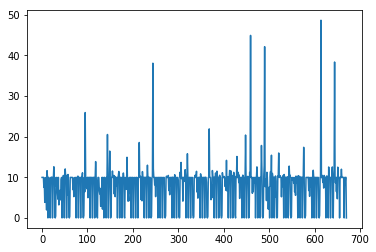

In [25]:
#total_time = total_time[(total_time.total_time > 10) ]
time = total_time[(total_time > 10)]
plt.plot(total_time['total_time'])
total_time.shape

## Initial distance

2017-10-04 13:38:42.550    0.0
2017-10-04 13:38:42.600    0.0
2017-10-04 13:38:42.650    0.0
2017-10-04 13:38:42.700    0.0
2017-10-04 13:38:42.750    0.0
2017-10-04 13:38:42.800    0.0
2017-10-04 13:38:42.850    0.0
2017-10-04 13:38:42.900    0.0
2017-10-04 13:38:42.950    0.0
2017-10-04 13:38:43.000    0.0
Name: distancePed, dtype: float64

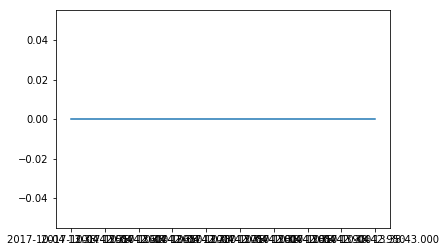

In [26]:
initial_distance = first[['session_id', 'scenario', 'pedId', 'distancePed']].copy()
initial_distance.head()
## desconfianza con el index 2 y su tiempo
#144.0	1.0	15.0

initial_distance = initial_distance[initial_distance.distancePed < 30]

testing_distance = df_joined[(df_joined.pedId == 0)  & (df_joined.scenario == 1)  & (df_joined.session_id == 150) ]
plt.plot(testing_distance['distancePed'])
testing_distance['distancePed']

In [27]:
max_values = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).max()
initial_distance = max_values[['session_id', 'scenario', 'pedId', 'distancePed']].copy()
initial_distance.head()

,session_id,scenario,pedId,distancePed
0,144.0,1.0,1.0,68.920520
1,144.0,1.0,3.0,69.359540
2,144.0,1.0,15.0,96.885284
3,144.0,2.0,0.0,27.102312
4,144.0,2.0,2.0,88.011610


In [28]:
initial_distance.shape

(671, 4)

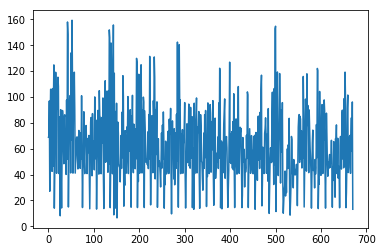

In [29]:
initial_distance =initial_distance[initial_distance.distancePed > 5]
plt.plot(initial_distance['distancePed'])

## Max Speed

In [30]:
max_speed = max_values[['session_id', 'scenario', 'pedId', 'speed']].copy()
max_speed.head()

,session_id,scenario,pedId,speed
0,144.0,1.0,1.0,11.669766
1,144.0,1.0,3.0,13.499710
2,144.0,1.0,15.0,25.851397
3,144.0,2.0,0.0,10.266865
4,144.0,2.0,2.0,20.055070


In [31]:
max_speed.shape

(671, 4)

## Before pedestrian crossed

In [32]:
def delete_unused_columns(df):
    df.drop('Pos_X', axis=1, inplace=True, errors='ignore') 
    df.drop('Pos_Y', axis=1, inplace=True, errors='ignore') 
    df.drop('distancePed', axis=1, inplace=True, errors='ignore') 
    df.drop('nextPedRunning', axis=1, inplace=True, errors='ignore') 
    df.drop('posPedX', axis=1, inplace=True, errors='ignore') 
    df.drop('posPedY', axis=1, inplace=True, errors='ignore') 
    df.drop('currentDistance', axis=1, inplace=True, errors='ignore') 
    df.drop('hadCollision', axis=1, inplace=True, errors='ignore') 

In [33]:
pedDidNotCross = df_joined[(df_joined.nextPedRunning == False)]
firstRowPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
lastRowPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()
meansPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
varPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).var()
delete_unused_columns(meansPedDidNotCross)
delete_unused_columns(varPedDidNotCross)


In [34]:
meansPedDidNotCross.shape

(558, 8)

In [35]:
meansPedDidNotCross[meansPedDidNotCross.isnull().values == True]

,session_id,scenario,pedId,speed,steering,brake,throttle,acceleration


In [36]:
varPedDidNotCross = varPedDidNotCross.dropna()
varPedDidNotCross.shape

(554, 8)

In [37]:
varPedDidNotCross[varPedDidNotCross.isnull().values == True]

,session_id,scenario,pedId,speed,steering,brake,throttle,acceleration


### Total time when running

In [44]:
whenPedCross = firstRowPedCross[['session_id', 'scenario', 'pedId']].copy()
firstRowPedCross['timeFinal'] = lastRowPedCross['time']
whenPedCross['total_time_when_running'] = (pd.to_datetime(firstRowPedCross['timeFinal']) - pd.to_datetime(firstRowPedCross['time'])).dt.total_seconds()
whenPedCross.head()

,session_id,scenario,pedId,total_time_when_running
0,144.0,1.0,1.0,5.239119
1,144.0,1.0,3.0,7.705014
2,144.0,1.0,15.0,7.848389
3,144.0,2.0,0.0,1.202199
4,144.0,2.0,2.0,4.975241


In [45]:
whenPedCrossMerge = pd.merge(varPedCross, meansPedCross , on=['session_id','scenario','pedId'],how='left',suffixes=('_when_running_var','_when_running_mean'))
delete_unused_columns(whenPedCrossMerge)
whenPedCrossTotalColumns = pd.merge(whenPedCrossMerge, whenPedCross , on=['session_id','scenario','pedId'],how='left')
whenPedCrossTotalColumns.head()


,session_id,scenario,pedId,speed_when_running_var,steering_when_running_var,brake_when_running_var,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running
0,144.0,1.0,1.0,11.033679,0.000174,0.035741,0.039745,0.083699,4.593110,0.476982,0.900460,0.739390,0.016767,5.239119
1,144.0,1.0,3.0,29.475829,0.000151,0.078618,0.000856,0.087210,5.276907,0.508684,0.839408,0.929774,-0.065371,7.705014
2,144.0,1.0,15.0,42.756716,0.001915,0.121984,0.035585,0.869046,6.933534,0.473303,0.769213,0.707442,-0.068940,7.848389
3,144.0,2.0,0.0,6.459006,0.000048,0.000000,0.044336,0.023489,6.170808,0.499042,1.000000,0.075305,0.314027,1.202199
4,144.0,2.0,2.0,55.270252,0.000429,0.075733,0.087892,0.212602,9.577210,0.504876,0.836788,0.630319,-0.078850,4.975241


In [46]:
whenPedCrossTotalColumns.shape

(655, 14)

In [47]:
whenPedCrossTotalColumns.isnull().values.any()

False

### Break Reaction Time

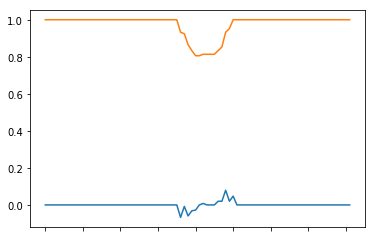

In [48]:
df_joined['brakeDiff'] = df_joined['brake'].diff()
pedCross = df_joined[(df_joined.nextPedRunning == True)]
dfNew = pedCross[(pedCross.session_id == 175.0) & (pedCross.scenario == 6.0) & (pedCross.pedId == 1.0)]
dfNew['brakeDiff'].plot()
dfNew['brake'].plot()

In [49]:
startReactionBrake = pedCross
finishReactionBrake = pedCross[(pedCross.brakeDiff < 0)]
finishReactionBrake.shape

(5210, 19)

In [50]:
firstRowPedCross = startReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
firstRowPressBrake = finishReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
firstRowPressBrake.shape
firstRowPedCross.shape

(655, 19)

In [51]:
reactionBrake = pd.merge(firstRowPedCross, firstRowPressBrake, on=['session_id','scenario','pedId'],how='left',suffixes=('_init','_fin'))
reactionBrake.head()

,session_id,scenario,pedId,time_init,Pos_X_init,Pos_Y_init,hadCollision_init,nextPedRunning_init,distancePed_init,speed_init,...,speed_fin,posPedX_fin,posPedY_fin,currentDistance_fin,time.1_fin,steering_fin,brake_fin,throttle_fin,acceleration_fin,brakeDiff_fin
0,144.0,1.0,1.0,2017-10-04 12:50:38.549538,-909.306458,80.473330,0.0,1.0,23.562530,7.754880,...,8.946986,-885.665649,72.027790,1178.73486,2017-10-04 12:50:39.586297,0.477104,0.980163,0.948409,0.072344,-0.019837
1,144.0,1.0,3.0,2017-10-04 12:50:47.530114,-839.965700,83.164460,0.0,1.0,39.895280,13.472353,...,13.034663,-801.989441,93.251990,1094.34827,2017-10-04 12:50:49.648762,0.533089,0.980163,0.948409,-0.009284,-0.019837
2,144.0,1.0,15.0,2017-10-04 12:52:29.782335,-62.199753,40.680523,0.0,1.0,49.374313,25.585112,...,25.720684,-20.775450,15.126913,355.46260,2017-10-04 12:52:29.893130,0.504952,0.900801,0.445304,0.069757,-0.099199
3,144.0,2.0,0.0,2017-10-04 12:57:42.500777,-933.749300,84.487495,0.0,1.0,7.474411,2.517837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144.0,2.0,2.0,2017-10-04 12:57:46.323453,-885.836365,77.199104,0.0,1.0,49.291360,19.412086,...,19.944923,-836.171631,80.316110,1141.20886,2017-10-04 12:57:47.485545,0.480339,0.964294,0.932540,-0.081133,-0.035706


In [52]:
reactionPressBrake = firstRowPedCross[['session_id', 'scenario', 'pedId', 'speed']].copy()
reactionPressBrake['reaction_time'] = (pd.to_datetime(reactionBrake['time_fin']) - pd.to_datetime(reactionBrake['time_init'])).dt.total_seconds()
reactionPressBrake = reactionPressBrake.dropna()
reactionPressBrake.head()

,session_id,scenario,pedId,speed,reaction_time
0,144.0,1.0,1.0,7.754880,1.048791
1,144.0,1.0,3.0,13.472353,2.106615
2,144.0,1.0,15.0,25.585112,0.079211
4,144.0,2.0,2.0,19.412086,1.161592
5,144.0,2.0,4.0,18.461056,1.275896


In [53]:
reactionPressBrake.shape

(531, 5)

In [54]:
reactionPressBrake.isnull().values.any()

False

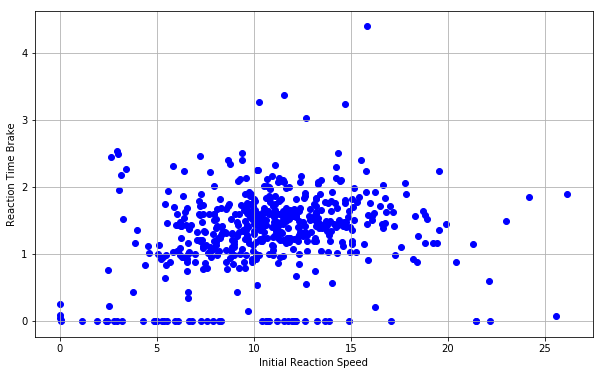

In [55]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed")
plt.ylabel("Reaction Time Brake")
reactionPressBrake = reactionPressBrake[reactionPressBrake.reaction_time < 50]

noHits = plt.scatter(reactionPressBrake['speed'], reactionPressBrake['reaction_time'], marker='o', c='b')

plt.grid(True)

plt.show()

In [56]:
reactionPressBrake.shape

(531, 5)

## Agressive driving measure: PKE

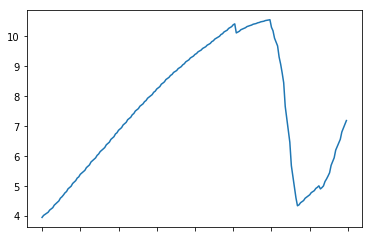

In [57]:
dfPKE = df_joined.copy()
dfNew = dfPKE[(dfPKE.session_id == 175.0) & (dfPKE.scenario == 6.0) & (dfPKE.pedId == 1.0)]
dfNew['speed'].plot()


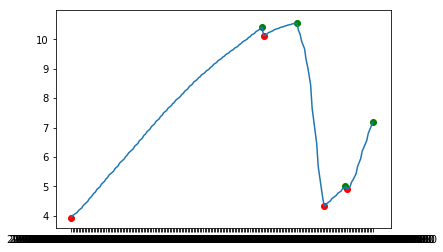

In [58]:
from scipy.signal import argrelextrema

df = dfNew.copy()
n=1 # number of points to be checked before and after 
# Find local peaks
df['min'] = df.iloc[argrelextrema(df.speed.values, np.less_equal, order=n)[0]]['speed']
df['max'] = df.iloc[argrelextrema(df.speed.values, np.greater_equal, order=n)[0]]['speed']

# Plot results
plt.scatter(df.index, df['min'], c='r')
plt.scatter(df.index, df['max'], c='g')
plt.plot(df.index, df['speed'])
plt.show()

In [59]:
df.head()

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,...,posPedY,currentDistance,time.1,steering,brake,throttle,acceleration,brakeDiff,min,max
2017-10-10 12:26:19.700,2017-10-10 12:26:19.670895,175.0,6.0,-958.071900,86.976036,0.0,1.0,0.0,72.838234,3.940402,...,70.21315,1236.63049,2017-10-10 12:26:19.695962,0.554833,1.0,0.880949,0.028599,0.0,3.940402,NaN
2017-10-10 12:26:19.750,2017-10-10 12:26:19.747599,175.0,6.0,-957.767151,87.014770,0.0,1.0,0.0,72.557940,4.007564,...,70.21315,1236.33411,2017-10-10 12:26:19.736068,0.554833,1.0,0.880949,0.067161,0.0,NaN,NaN
2017-10-10 12:26:19.800,2017-10-10 12:26:19.784197,175.0,6.0,-957.620600,87.032710,0.0,1.0,0.0,72.406900,4.041331,...,70.21315,1236.19153,2017-10-10 12:26:19.795728,0.554833,1.0,0.876982,0.033768,0.0,NaN,NaN
2017-10-10 12:26:19.850,2017-10-10 12:26:19.824805,175.0,6.0,-957.457800,87.052020,0.0,1.0,0.0,72.263140,4.078692,...,70.21315,1236.03308,2017-10-10 12:26:19.835834,0.554833,1.0,0.876982,0.037361,0.0,NaN,NaN
2017-10-10 12:26:19.900,2017-10-10 12:26:19.861903,175.0,6.0,-957.303833,87.069700,0.0,1.0,0.0,72.103400,4.113738,...,70.21315,1235.88300,2017-10-10 12:26:19.895994,0.554833,1.0,0.873014,0.035045,0.0,NaN,NaN


In [60]:
import math

def aggressiveDriverPKE(df):
    vi = None
    acumulative = 0
    distance = df.currentDistance.max() - df.currentDistance.min()
    df = df[(df['min'].notnull() | df['max'].notnull())]
    for index, row in df.iterrows():
        if (not math.isnan(row['min'])):
            vi = row['min']
        else:
            if (vi is None):
                continue
            else:
                if (not math.isnan(row['max'])):
                    vf = row['max']
                    acumulative += vf*vf - vi * vi
                    vi = None
                    vf = None

    return acumulative/distance

In [61]:
n=1 # number of points to be checked before and after 
# Find local peaks
dfPKE = df_joined.copy()

dfPKE['min'] = dfPKE.iloc[argrelextrema(dfPKE.speed.values, np.less_equal, order=n)[0]]['speed']
dfPKE['max'] = dfPKE.iloc[argrelextrema(dfPKE.speed.values, np.greater_equal, order=n)[0]]['speed']

dfPKE = dfPKE[['session_id', 'scenario', 'pedId', 'currentDistance', 'min','max']]
total_PKE = dfPKE.groupby(['session_id', 'scenario', 'pedId'], as_index=False).apply(aggressiveDriverPKE).to_frame('PKE').reset_index()

total_PKE.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


,session_id,scenario,pedId,PKE
0,144.0,1.0,1.0,1.110623
1,144.0,1.0,3.0,0.084626
2,144.0,1.0,15.0,5.246326
3,144.0,2.0,0.0,3.749752
4,144.0,2.0,2.0,2.969647


In [62]:
total_PKE.shape

(671, 4)

### Steering PKE


In [63]:
dfSteeringPKE = df_joined.copy()
dfSteeringPKE['min'] = dfSteeringPKE.iloc[argrelextrema(dfSteeringPKE.speed.values, np.less_equal, order=n)[0]]['steering']
dfSteeringPKE['max'] = dfSteeringPKE.iloc[argrelextrema(dfSteeringPKE.speed.values, np.greater_equal, order=n)[0]]['steering']

dfSteeringPKE = dfSteeringPKE[['session_id', 'scenario', 'pedId', 'currentDistance', 'min','max']]
total_steering_PKE = dfSteeringPKE.groupby(['session_id', 'scenario', 'pedId'], as_index=False).apply(aggressiveDriverPKE).to_frame('PKE_Steering').reset_index()

total_steering_PKE.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


,session_id,scenario,pedId,PKE_Steering
0,144.0,1.0,1.0,-0.000432
1,144.0,1.0,3.0,0.000000
2,144.0,1.0,15.0,0.000170
3,144.0,2.0,0.0,-0.001185
4,144.0,2.0,2.0,-0.000258


In [64]:
total_steering_PKE.shape

(671, 4)

## Backup PKE's

In [65]:
total_PKE.to_csv('pke_fixed_time.csv', index=False)
total_steering_PKE.to_csv('steering_pke_fixed_time.csv', index=False)

total_PKE = pd.read_csv("pke_fixed_time.csv")
total_steering_PKE = pd.read_csv("steering_pke_fixed_time.csv")


# Merge dataframes

In [66]:
df_suffix = pd.merge(means_cleaned, variance_cleaned, on=['session_id','scenario','pedId'],how='left',suffixes=('_total_mean','_total_var'))
df_suffix = pd.merge(df_suffix, total_time, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, initial_distance, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, max_speed, on=['session_id','scenario','pedId'],how='left',suffixes=('','_max'))
df_suffix = pd.merge(df_suffix, total_PKE, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, total_steering_PKE, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, reactionPressBrake, on=['session_id','scenario','pedId'],how='right',suffixes=('','_react'))
df_suffix.head()

,session_id,scenario,pedId,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,...,brake_total_var,throttle_total_var,acceleration_total_var,total_time,distancePed,speed,PKE,PKE_Steering,speed_react,reaction_time
0,144.0,1.0,1.0,0.000,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,...,0.021339,0.032907,0.050404,9.958178,68.920520,11.669766,1.110623,-0.000432,7.754880,1.048791
1,144.0,1.0,3.0,0.000,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,...,0.065360,0.002429,0.068962,9.961018,69.359540,13.499710,0.084626,0.000000,13.472353,2.106615
2,144.0,1.0,15.0,0.075,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,...,0.105119,0.076302,0.705761,9.941460,96.885284,25.851397,5.246326,0.000170,25.585112,0.079211
3,144.0,2.0,2.0,0.000,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,...,0.055982,0.112551,0.159198,7.505478,88.011610,20.055070,2.969647,-0.000258,19.412086,1.161592
4,144.0,2.0,4.0,0.000,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,...,0.102442,0.079023,0.158822,8.681609,105.973686,19.697004,4.033468,0.000066,18.461056,1.275896


### Scenario Info

In [67]:
## Scenario 1 : Low pedestrian   | High Visibility | Low Traffic
## Scenario 2 : High pedestrian   | High Visibility | Low Traffic
## Scenario 3 : Normal pedestrian | Low Visibility | Low Traffic
## Scenario 4 : Normal pedestrian | High Visibility | Low Traffic 
## Scenario 6 : Normal pedestrian | High Visibility | High Traffic 
ped = {1: 0, 2: 2, 3: 1, 4: 1, 6: 1}
df_suffix['pedestriansLevel'] = df_suffix['scenario'].map(ped)

visibility = {1: 1, 2: 1, 3: 0, 4: 1, 6: 1}
df_suffix['visibilityLevel'] = df_suffix['scenario'].map(visibility)

traffic = {1: 0, 2: 0, 3: 0, 4: 1, 6: 1}
df_suffix['trafficLevel'] = df_suffix['scenario'].map(traffic)

### Info Participants

In [68]:
participantsData = pd.read_csv("InfoParticipants.csv", index_col=0) 
df_suffix = pd.merge(df_suffix, participantsData , on=['session_id'],how='left')

gender = {'M': 0, 'F': 1}
df_suffix['gender'] = df_suffix['gender'].map(gender)

job = {'Student': 0, 'PhD Student': 1, 'Researcher': 2, 'Project Coordinator': 3, 'Research Associate': 4, 'PA': 5, 'Events': 6}
df_suffix['job'] = df_suffix['job'].map(job)

LatestDegree = {'Bachelor': 0, 'Master': 1, 'PhD': 2, 'High School': 3, 'Uni Diploma': 4, 'University': 5}
df_suffix['LatestDegree'] = df_suffix['LatestDegree'].map(LatestDegree)

df_suffix.head()

,session_id,scenario,pedId,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,...,trafficLevel,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets
0,144.0,1.0,1.0,0.000,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,...,0,0,32,0,0,2,0,10,1.0,0
1,144.0,1.0,3.0,0.000,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,...,0,0,32,0,0,2,0,10,1.0,0
2,144.0,1.0,15.0,0.075,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,...,0,0,32,0,0,2,0,10,1.0,0
3,144.0,2.0,2.0,0.000,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,...,0,0,32,0,0,2,0,10,1.0,0
4,144.0,2.0,4.0,0.000,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,...,0,0,32,0,0,2,0,10,1.0,0


In [69]:
def delete_common_columns(df):
    df.drop('session_id', axis=1, inplace=True, errors='ignore') 
    #df.drop('pedId', axis=1, inplace=True, errors='ignore')

delete_common_columns(df_suffix)
df_scenario_cluster = df_suffix.copy()
df_suffix.drop('scenario', axis=1, inplace=True, errors='ignore') 
df_suffix.rename(columns={'speed':'max_speed'}, inplace=True)


In [81]:
df_suffix.isnull().values.any()

df_suffix = df_suffix.dropna()

is_NaN = df_suffix.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_suffix[row_has_NaN]
rows_with_NaN

,pedId,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,...,trafficLevel,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets


In [82]:
df_suffix.shape

(487, 31)

In [83]:
reactionPressBrake.shape

(531, 5)

In [84]:
def plot_corr(df, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                                Expect a darkred line running from top left to bottom right
    """

    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

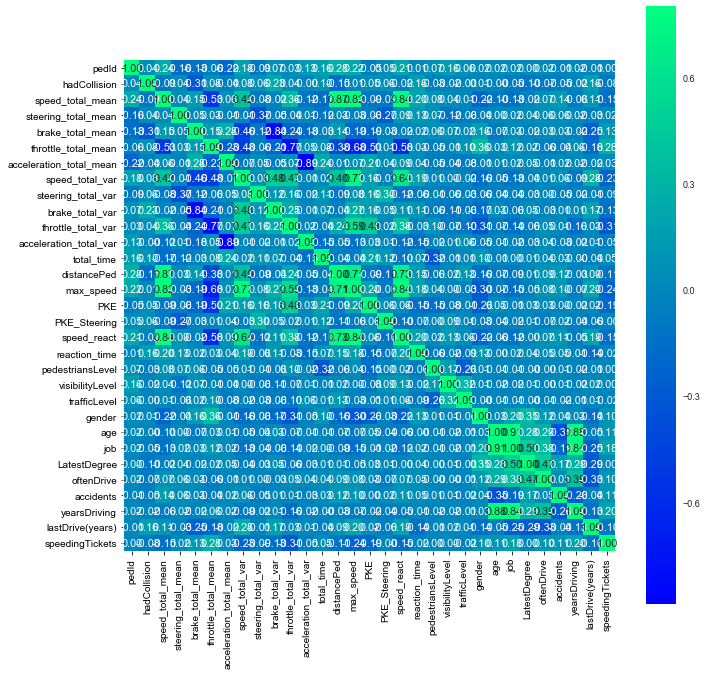

In [85]:
import seaborn as sns

corrmat = df_suffix.corr()
f, ax = plt.subplots(figsize=(11,11))
sns.set(font_scale=0.9)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap="winter")
plt.show()

In [86]:
df_suffix.corr()

,pedId,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,...,trafficLevel,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets
pedId,1.000000,0.036098,0.243098,-0.157353,-0.132705,-0.057028,-0.216670,0.184520,-0.085077,0.071339,...,0.057628,0.018768,0.016695,0.016091,0.004568,0.023865,-0.007341,0.018528,-0.005448,0.001453
hadCollision,0.036098,1.000000,-0.092515,0.037797,-0.307338,0.078338,-0.038211,0.084492,0.055792,0.234562,...,-0.002186,0.013957,-0.001049,-0.051237,-0.104708,-0.071881,-0.047623,-0.017168,0.162586,-0.084056
speed_total_mean,0.243098,-0.092515,1.000000,0.038125,0.150703,-0.530275,0.058554,0.416418,-0.079519,-0.023254,...,0.009721,-0.218395,-0.098295,-0.133490,-0.022453,0.072713,0.142181,-0.057820,0.105994,-0.146476
steering_total_mean,-0.157353,0.037797,0.038125,1.000000,0.046584,0.026113,-0.012353,-0.006437,-0.370027,-0.047470,...,-0.055111,-0.035185,0.004657,0.020350,0.035687,0.061575,0.057976,0.019519,-0.026634,0.024544
brake_total_mean,-0.132705,-0.307338,0.150703,0.046584,1.000000,0.151528,0.281206,-0.462397,-0.116423,-0.836130,...,0.023809,0.155768,-0.073350,0.031128,-0.017561,0.030183,0.027806,-0.017838,-0.246724,0.126529
throttle_total_mean,-0.057028,0.078338,-0.530275,0.026113,0.151528,1.000000,-0.229846,-0.479566,-0.061992,-0.206804,...,0.096391,0.359531,0.026743,0.120021,0.016297,-0.063927,-0.044251,0.063399,-0.181445,0.278079
acceleration_total_mean,-0.216670,-0.038211,0.058554,-0.012353,0.281206,-0.229846,1.000000,-0.073324,0.050271,-0.052841,...,-0.081640,-0.013668,0.013619,0.021028,0.051537,-0.010028,0.024511,0.017835,-0.021916,0.029791
speed_total_var,0.184520,0.084492,0.416418,-0.006437,-0.462397,-0.479566,-0.073324,1.000000,0.077129,0.476211,...,-0.018678,-0.162815,-0.048331,-0.128702,-0.039758,0.012872,0.060265,-0.092264,0.276335,-0.225344
steering_total_var,-0.085077,0.055792,-0.079519,-0.370027,-0.116423,-0.061992,0.050271,0.077129,1.000000,0.115459,...,-0.030528,-0.064359,-0.035147,-0.037447,-0.027202,0.003813,-0.052410,-0.024786,-0.012400,-0.087671
brake_total_var,0.071339,0.234562,-0.023254,-0.047470,-0.836130,-0.206804,-0.052841,0.476211,0.115459,1.000000,...,-0.063371,-0.174137,0.031748,-0.060385,0.051223,-0.029871,0.013817,0.013546,0.174979,-0.133782


## Mold Data

### Data Types

Inspect data types to see if there are any issues.  Data should be numeric.

In [87]:
df = df_suffix
#hadCollision_map = {True : 1, False : 0}
df['hadCollision'] = np.where(df['hadCollision'] == 0, 0, 1)

In [88]:

cols_at_end = ['hadCollision']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]
df.head(5)

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,...,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision
0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,...,0,32,0,0,2,0,10,1.0,0,0
1,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,...,0,32,0,0,2,0,10,1.0,0,0
2,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,...,0,32,0,0,2,0,10,1.0,0,1
3,2.0,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,...,0,32,0,0,2,0,10,1.0,0,0
4,4.0,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,...,0,32,0,0,2,0,10,1.0,0,0


### Backup merge data

In [89]:
df.to_csv('mergeData_fixed_time.csv', index=False)